
<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
Digital Image Processing <br>
<font color=2565AE size=5>
Department Of Mathematical Sciences <br>
Spring 2025<br>
<font color=3C99D size=5>
Course Project <br>
</div>


---



#### Team members: Raya Namazi - Sina Daneshgar
#### Student ID: 402100561 - 401100369

In [ ]:
import numpy as np
import cv2

## Section 1: Finding the Objects

In this part, we are going to implement functions to find and indicate samples of `template.png` in `input.jpg`. We will use correlation based methods to achieve this. You can see chapter 13.3 of the course reference for more information on how to do this. As a brief summary, there are four methods you can consider:


1.   **Cross Correlation**
2.   **Zero-mean Cross Correlation**
3.  **Sum of Squared Differences (SSD)**
4.  **Normalized Cross Correlation**

You are free to use any of the above methods (or a combination of them) you prefer (it is recommended to use Normalized Cross Correlation).



In [ ]:
def find_template(img: np.ndarray, template: np.ndarray):
  # TODO: return a mask indicating the templates
  pass

Next function should draw a rectangle around the matches. Input is a masked image which is generated by the above function, indicating the matches.

In [ ]:
def draw_bars(img: np.ndarray, template: np.ndarray, mask: np.ndarray):
  # TODO: Draw bars on the matched templates
  pass

Now execute above functions for `input.jpg` and find matches for `temple.png`. Indicate the matches by drawing a rectangle around them and save the resulting image as `output1.jpg`. Your score for this part depends on the number of correct and incorrect matches.

In [ ]:
# TODO
# Apply the above functions and save the resulting image


## Section 2: Image Completion

We will study and implement two methods for image completion.

### Method 1: Texture Synthesis

One way to complete a removed part of an image is to try regenerating the texture of its near pixels to cover it using texture synthesis. Texture synthesis is the process of constructing a large digital image from a small digital sample image by taking advantage of its structural content.

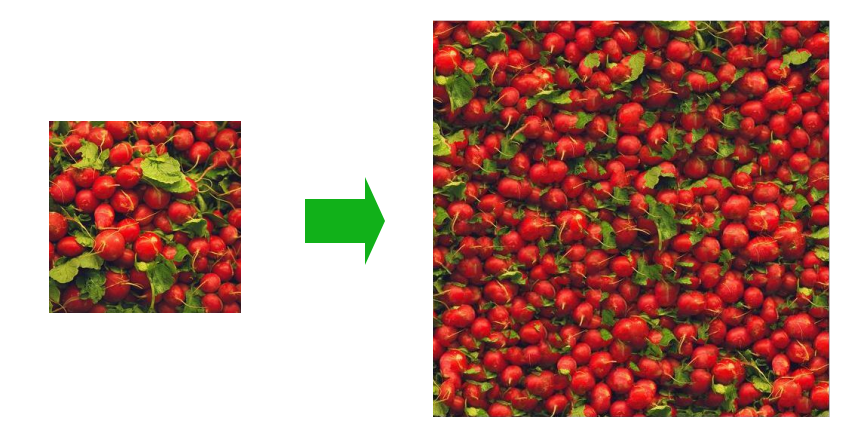

The method we are going to implement is based on the following paper:

 https://people.eecs.berkeley.edu/~efros/research/quilting/quilting.pdf

Complete the following function to apply texture synthesis to generate a larger image (with shape `result_shape`) with the given texture. `patch_size` indicated the size of the patch covered in each iteration. `overlap` is an integer indicating the number of overlaping pixels between any two patches.

**Note:** To avoid complicating this function, you may need to implement other helper functions and use them. implement them in the next cell.


In [ ]:
# Helper functions

In [ ]:
def apply_texture_synthesis(texture: np.ndarray, result_shape, patch_size, overlap):
  # TODO: output the synthesised image
  pass

Apply this function on `texture1.jpg`, `texture2.jpg` and `texture3.jpg` and save the results as `output-synthesis1.jpg`, `output-synthesis2.jpg` and `output-synthesis3.jpg`, respectively. Dimension of the results should be $2400 \times 2400$. You can choose `patch_size` and `overlap` properly to get the best result. Your score on this part depends on the quality of the results.

In [ ]:
# TODO: generate and save the results

### Method 2: Patch Match

**Patch Match** is a method for image inpainting introduced in the following work:

Website: https://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/index.php

Paper: https://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/patchmatch.pdf


Implement the following function to apply patch match on image `A` from image `B`:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/Image_Processing/Main_Project"

/content/drive/MyDrive/Image_Processing/Main_Project


In [3]:
ls

input.jpg             Project.zip   texture2.jpg
patchmatch-input.jpg  template.png  texture3.jpg
Project.ipynb         texture1.jpg  Unzipping.ipynb


In [11]:
import torch
import random
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [5]:
# Your helper functions here

def compute_patch_distance(A, B, ax, ay, bx, by, patch_size):
    """Compute the L2 distance between two patches."""
    half = patch_size // 2
    patchA = A[ay-half:ay+half+1, ax-half:ax+half+1]
    patchB = B[by-half:by+half+1, bx-half:bx+half+1]
    if patchA.shape != patchB.shape:
        return float('inf')
    return np.sum((patchA.astype(np.float32) - patchB.astype(np.float32)) ** 2)

In [6]:
def perform_patch_match(A, B, patch_size, iterations=4):
    h, w, _ = A.shape
    half = patch_size // 2

    # Nearest Neighbor Field (NNF): stores the offset to best patch in B
    nnf = np.zeros((h, w, 2), dtype=np.int32)

    # Random initialization of NNF
    for y in range(half, h - half):
        for x in range(half, w - half):
            bx = random.randint(half, w - half - 1)
            by = random.randint(half, h - half - 1)
            nnf[y, x] = [bx - x, by - y]

    for it in range(iterations):
        y_range = range(half, h - half)
        x_range = range(half, w - half)
        if it % 2 == 1:
            y_range = reversed(y_range)
            x_range = reversed(x_range)

        for y in y_range:
            for x in x_range:
                best_offset = nnf[y, x]
                best_dist = compute_patch_distance(A, B, x, y, x + best_offset[0], y + best_offset[1], patch_size)

                # Propagation
                for dx, dy in [(-1, 0), (0, -1)] if it % 2 == 0 else [(1, 0), (0, 1)]:
                    nx, ny = x + dx, y + dy
                    if half <= nx < w - half and half <= ny < h - half:
                        offset = nnf[ny, nx]
                        bx = x + offset[0]
                        by = y + offset[1]
                        if half <= bx < w - half and half <= by < h - half:
                            dist = compute_patch_distance(A, B, x, y, bx, by, patch_size)
                            if dist < best_dist:
                                best_dist = dist
                                best_offset = [bx - x, by - y]

                # Random search
                rs_max = max(w, h)
                rs = rs_max
                while rs >= 1:
                    min_x = max(x + best_offset[0] - rs, half)
                    max_x = min(x + best_offset[0] + rs, w - half - 1)
                    min_y = max(y + best_offset[1] - rs, half)
                    max_y = min(y + best_offset[1] + rs, h - half - 1)

                    bx = random.randint(min_x, max_x)
                    by = random.randint(min_y, max_y)
                    dist = compute_patch_distance(A, B, x, y, bx, by, patch_size)
                    if dist < best_dist:
                        best_dist = dist
                        best_offset = [bx - x, by - y]
                    rs //= 2

                nnf[y, x] = best_offset

    # Reconstruct
    result = A.copy()
    for y in range(half, h - half):
        for x in range(half, w - half):
            offset = nnf[y, x]
            bx = x + offset[0]
            by = y + offset[1]
            result[y, x] = B[by, bx]

    return result

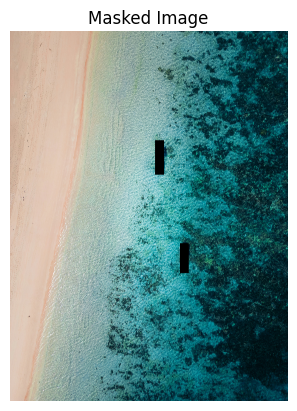

In [7]:
# Load image
img = cv2.imread("patchmatch-input.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for visualization

# Clone original
masked = img.copy()

# Manually mask boat regions (black-out the boats)
cv2.rectangle(masked, (3160, 2380), (3160 + 190, 2380 + 750), (0, 0, 0), -1)
cv2.rectangle(masked, (3695, 4624), (3695 + 190, 4624 + 650), (0, 0, 0), -1)

plt.imshow(masked)
plt.title("Masked Image")
plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Utility: Create hole in image ---
def create_rectangular_hole(image, x, y, width, height):
    image_copy = image.copy()
    image_copy[y:y+height, x:x+width] = 255
    return image_copy

# --- Step 1: Find border pixels ---
def _get_border_pixels(mask):
    borders = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))) - mask
    return np.argwhere(borders > 0)

# --- Step 2: Extract patch ---
def _extract_patch(image, mask, y, x, patch_size, height, width):
    half_patch = patch_size // 2
    y1, y2 = max(0, y - half_patch), min(height, y + half_patch + 1)
    x1, x2 = max(0, x - half_patch), min(width, x + half_patch + 1)
    patch = image[y1:y2, x1:x2]
    patch_mask = mask[y1:y2, x1:x2]
    return patch, patch_mask, (y1, y2, x1, x2)

# --- Step 3: Find best match for a patch ---
def _find_best_match(image, inv_mask, patch, patch_mask, y, x, patch_size, search_window, height, width):
    half_patch = patch_size // 2
    best_match = None
    best_distance = float('inf')
    for _ in range(200):
        ry = random.randint(max(0, y - search_window), min(height - patch_size, y + search_window))
        rx = random.randint(max(0, x - search_window), min(width - patch_size, x + search_window))

        if inv_mask[ry + half_patch, rx + half_patch] == 0:
            continue

        dy1 = (patch.shape[0] // 2) - half_patch
        dy2 = dy1 + patch.shape[0]
        dx1 = (patch.shape[1] // 2) - half_patch
        dx2 = dx1 + patch.shape[1]

        ref_patch = image[ry + dy1 : ry + dy2, rx + dx1 : rx + dx2]

        if ref_patch.shape != patch.shape:
            continue

        valid_mask = (patch_mask != 255)[..., np.newaxis]
        distance = np.sum(((patch - ref_patch) * valid_mask) ** 2)

        if distance < best_distance:
            best_distance = distance
            best_match = ref_patch

    return best_match

# --- Step 4: Apply selected patch ---
def _apply_patch(filled, mask, best_match, patch, patch_mask, y1, y2, x1, x2):
    filled[y1:y2, x1:x2] = np.where(
        patch_mask[..., np.newaxis] == 255,
        best_match,
        patch
    )
    mask[y1:y2, x1:x2] = 0

# --- Main PatchMatch Function ---
def perform_patch_match(img, mask, patch_size=31, iterations=15, search_window=300):
    image = img.astype(np.float32)
    height, width = image.shape[:2]
    inv_mask = 255 - mask
    filled = image.copy()
    overall_progress = tqdm(total=iterations, desc='Overall Progress', position=0)

    for iter in range(iterations):
        border_pixels = _get_border_pixels(mask)
        random.shuffle(border_pixels)
        pixel_progress = tqdm(total=len(border_pixels), desc=f'Iteration {iter+1}', position=1, leave=False)

        for y, x in border_pixels:
            patch, patch_mask, (y1, y2, x1, x2) = _extract_patch(filled, mask, y, x, patch_size, height, width)
            if np.all(patch_mask == 255):
                pixel_progress.update(1)
                continue

            best_match = _find_best_match(
                filled, inv_mask, patch, patch_mask,
                y, x, patch_size, search_window, height, width
            )
            if best_match is not None:
                _apply_patch(filled, mask, best_match, patch, patch_mask, y1, y2, x1, x2)
            pixel_progress.update(1)

        pixel_progress.close()
        overall_progress.update(1)

    overall_progress.close()
    return filled.astype(np.uint8)

# --- I/O and Visualization ---
original_image_bgr = cv2.imread('patchmatch-input.jpg')
original_image_np = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB)

# --- Define Holes ---
x1, y1 = 3160, 2380
width1, height1 = 190, 750
x2, y2 = 3695, 4624
width2, height2 = 190, 650

image_with_hole_np = create_rectangular_hole(original_image_np, x1, y1, width1, height1)
image_with_hole_np = create_rectangular_hole(image_with_hole_np, x2, y2, width2, height2)

mask = np.zeros_like(image_with_hole_np[:,:,0])
mask[y1:y1+height1, x1:x1+width1] = 255
mask[y2:y2+height2, x2:x2+width2] = 255

# --- Run PatchMatch ---
result = perform_patch_match(
    image_with_hole_np,
    mask,
    patch_size=15,
    iterations=20,
    search_window=400
)

# --- Save and Visualize ---
cv2.imwrite("output-patchmatch.jpg", cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
print("Saved full-resolution image as 'output-patchmatch.jpg'")

scale_factor = 4
resized_result = cv2.resize(result, (result.shape[1] // scale_factor, result.shape[0] // scale_factor))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_np[::scale_factor, ::scale_factor])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Patched Result")
plt.imshow(resized_result)
plt.axis('off')
plt.show()

Iteration 3:  70%|██████▉   | 2481/3568 [00:10<00:03, 273.16it/s]

From `patchmatch-input.jpg`, remove the two boats (you can do it manually) and recover their background using patchmatch. Choose proper parameters to get the best possible result.

## Section 3: Removing Objects and Completing the Image

For the last part, we will use above functions to remove the detected objects from section 1 and complete the initial image.

First, Remove the matched objects from `input.jpg` and plot the result. You may do this by simply setting the intensity of the matched pixels to 0 (or anything else).

In [30]:
# TODO: Remove Objects

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def crop_border(image_path):
    img = Image.open(image_path)
    width, height = img.size
    cropped_img = img.crop((80, 80, width - 90, height - 80))
    return cropped_img

def find_template(img_gray: np.ndarray, template_gray: np.ndarray, scales: list):
    all_detections = []
    (tH, tW) = template_gray.shape[:2]

    for scale in scales:
        resized_template = cv2.resize(template_gray, (int(tW * scale), int(tH * scale)))
        if resized_template.shape[0] > img_gray.shape[0] or resized_template.shape[1] > img_gray.shape[1] or \
           resized_template.shape[0] == 0 or resized_template.shape[1] == 0:
            continue

        result = cv2.matchTemplate(img_gray, resized_template, cv2.TM_CCOEFF_NORMED)
        loc = np.where(result >= 0.45)
        for pt in zip(*loc[::-1]):
            score = result[pt[1], pt[0]]
            all_detections.append((score, (pt[0], pt[1], resized_template.shape[1], resized_template.shape[0])))

    return all_detections

def draw_bars(img: np.ndarray, detections: list, final_threshold: float = 0.5, fill: bool = False):
    boxes = []
    confidences = []
    expand = 100
    for (score, (x, y, w, h)) in detections:
        if score >= final_threshold:
            boxes.append([x, y, w, h])
            confidences.append(float(score))

    if len(boxes) > 0:
        rects, weights = cv2.groupRectangles(boxes, groupThreshold=1, eps=0.15)
    else:
        rects = []

    img_with_bars = img.copy()
    mask = np.zeros(img.shape[:2], dtype=np.uint8)

    if len(rects) > 0:
        for (x, y, w_rect, h_rect) in rects:
            x_exp = max(x - int(0.90 * expand), 0)
            y_exp = max(y - int(1.30 * expand), 0)
            w_exp = w_rect + int(2 * 0.70 * expand)
            h_exp = h_rect + int(2 * 0.70 * expand)

            if fill:
                # Fill image and mask for inpainting
                cv2.rectangle(img_with_bars, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (255, 255, 255), thickness=-1)
                cv2.rectangle(mask, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), 255, thickness=-1)
            else:
                cv2.rectangle(img_with_bars, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 0, 255), thickness=3)

    return img_with_bars, mask

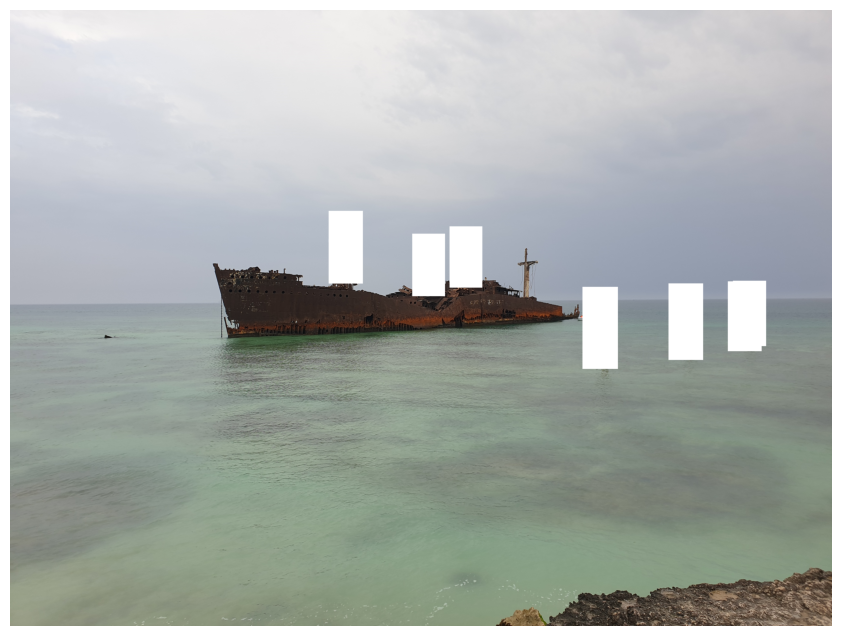

In [37]:
img_patchmatch = cv2.imread('input.jpg')
template_pathcmatch = np.array(crop_border('template.png'))
img_gray_patchmatch = cv2.cvtColor(img_patchmatch, cv2.COLOR_BGR2GRAY)
template_gray_patchmatch = cv2.cvtColor(template_pathcmatch, cv2.COLOR_BGR2GRAY)

scales = np.linspace(0.4, 1.0, 10)

all_detections_patchmatch = find_template(img_gray_patchmatch, template_gray_patchmatch, scales)

final_threshold = 0.60

output_image_patchmatch, mask_patchmatch = draw_bars(
    img_patchmatch.copy(),
    all_detections_patchmatch,
    final_threshold=final_threshold,
    fill=True
)

plt.figure(figsize=(12, 8))
output_rgb_patchmatch = cv2.cvtColor(output_image_patchmatch, cv2.COLOR_BGR2RGB)
plt.imshow(output_rgb_patchmatch)
plt.axis('off')
plt.show()

Now, apply texture synthesis or patch match (or both) to complete the removed part of the image. Save the result as `output-complete.jpg`. Your score on this part depends on the qulity of the completed parts.

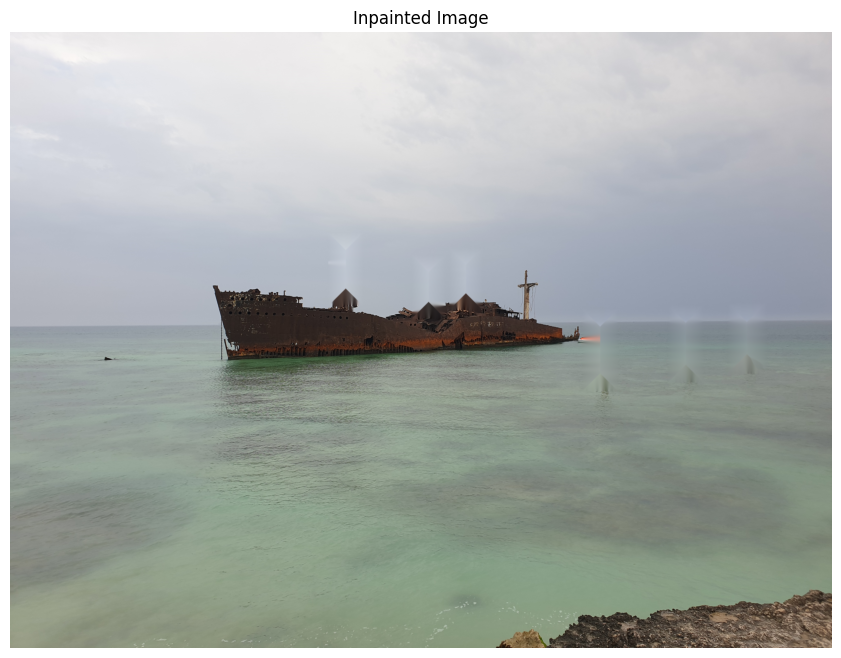

In [28]:
# Load and prepare images
img_patchmatch = cv2.imread('input.jpg')
template_patchmatch = np.array(crop_border('template.png'))
img_gray_patchmatch = cv2.cvtColor(img_patchmatch, cv2.COLOR_BGR2GRAY)
template_gray_patchmatch = cv2.cvtColor(template_patchmatch, cv2.COLOR_BGR2GRAY)

# Match templates
scales = np.linspace(0.4, 1.0, 10)
detections = find_template(img_gray_patchmatch, template_gray_patchmatch, scales)

# Remove detected parts and generate mask
final_threshold = 0.60
img_removed, inpaint_mask = draw_bars(img_patchmatch.copy(), detections, final_threshold=final_threshold, fill=True)

# Inpainting using Telea (alternative to PatchMatch)
inpainted_img = cv2.inpaint(img_removed, inpaint_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Save and display result
cv2.imwrite('output-complete.jpg', inpainted_img)

# Show result
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(inpainted_img, cv2.COLOR_BGR2RGB))
plt.title("Inpainted Image")
plt.axis("off")
plt.show()